In [424]:
# Ensure we inline plots
%matplotlib inline

# Imports
import pandas
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import *
from scipy.sparse import *
import itertools
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os
import matplotlib.cm as cm
import seaborn as sns

In [796]:
from matplotlib.colors import LinearSegmentedColormap
import numpy.ma as ma

## Data

In [425]:
# http://www.gbif.org/occurrence/search?TAXON_KEY=359&YEAR=2014#
# This is data for all Mammals in 2014 across the whole planet
#data = pandas.read_csv('Data/Mammalia_2014.csv', sep='\t')

# http://www.gbif.org/occurrence/search?TAXON_KEY=212&TAXON_KEY=8407975&TAXON_KEY=358&TAXON_KEY=359&COUNTRY=US&YEAR=2015#
# This is data for all Mammals, Reptiles, Amphibians, and Birds for the US in the year 2015
data = pandas.read_csv('Data/US_MAAR_2015.csv', sep='\t')

In [550]:
# Let's examine the data to ensure we've imported it correctly
data.head()

,gbifid,datasetkey,occurrenceid,kingdom,phylum,class,order,family,genus,species,...,recordnumber,identifiedby,rights,rightsholder,recordedby,typestatus,establishmentmeans,lastinterpreted,mediatype,issue
0,1088897477,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1179388,Animalia,Chordata,Aves,Charadriiformes,Laridae,Larus,Larus occidentalis,...,NaN,NaN,© asemerdj some rights reserved,asemerdj,asemerdj,NaN,NaN,2016-04-16T13:44Z,NaN,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
1,1088897966,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1202967,Animalia,Chordata,Aves,Accipitriformes,Accipitridae,Accipiter,Accipiter cooperii,...,NaN,NaN,© Judith Lopez Sikora some rights reserved,Judith Lopez Sikora,Judith Lopez Sikora,NaN,NaN,2016-04-16T09:52Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
2,1088898290,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1219316,Animalia,Chordata,Aves,Anseriformes,Anatidae,Anas,Anas platyrhynchos,...,NaN,NaN,© hummer56 some rights reserved,hummer56,hummer56,NaN,NaN,2016-04-16T10:55Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
3,1088898553,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1230163,Animalia,Chordata,Mammalia,Rodentia,Sciuridae,Sciurus,Sciurus carolinensis,...,NaN,NaN,by Scott Loarie no rights reserved,Scott Loarie,Scott Loarie,NaN,NaN,2016-04-17T11:45Z,NaN,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
4,1088898658,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1232050,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,Sceloporus olivaceus,...,NaN,NaN,© kg9239 some rights reserved,kg9239,kg9239,NaN,NaN,2016-04-17T11:55Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84


In [556]:
# Examine the columns available to us
data.columns

Index([u'gbifid', u'datasetkey', u'occurrenceid', u'kingdom', u'phylum',
       u'class', u'order', u'family', u'genus', u'species',
       u'infraspecificepithet', u'taxonrank', u'scientificname',
       u'countrycode', u'locality', u'publishingorgkey', u'decimallatitude',
       u'decimallongitude', u'coordinateuncertaintyinmeters',
       u'coordinateprecision', u'elevation', u'elevationaccuracy', u'depth',
       u'depthaccuracy', u'eventdate', u'day', u'month', u'year', u'taxonkey',
       u'specieskey', u'basisofrecord', u'institutioncode', u'collectioncode',
       u'catalognumber', u'recordnumber', u'identifiedby', u'rights',
       u'rightsholder', u'recordedby', u'typestatus', u'establishmentmeans',
       u'lastinterpreted', u'mediatype', u'issue'],
      dtype='object')

In [427]:
# Create a subset data frame that just contains the columns that we need
species_lat_longs = data[['species','decimallatitude','decimallongitude']]

# Drop all NaNs
species_lat_longs = species_lat_longs.dropna()

# Examine the head of the data frame
species_lat_longs.head()

,species,decimallatitude,decimallongitude
0,Larus occidentalis,33.09001,-117.29457
1,Accipiter cooperii,32.88612,-97.28197
2,Anas platyrhynchos,37.25697,-115.15350
3,Sciurus carolinensis,37.32783,-121.89144
4,Sceloporus olivaceus,32.54739,-98.77572


In [428]:
species_array = species_lat_longs.species.unique()
print "Found %d unique species in the dataset" % len(species_array)

Found 1300 unique species in the dataset


In [429]:
# Create a species dictionary to lookup a species id by name
species_dictionary = {}
# Create a species lookup dictionary to lookup a species name by id
species_lookup_dict = {}
for i, s in enumerate(species_array):
    species_dictionary[s] = i
    species_lookup_dict[i] = s

In [430]:
# Create the 10.0 x 10.0 lat-long grid squares
# Changing the size of the lat-long grid squares will have a large effect on the results
lats = np.arange(-90, 91, 3)
longs = np.arange(-180, 181, 3)

In [431]:
# Generate the grid
grids = list(itertools.product(lats, longs))

In [432]:
num_grids = len(grids)
print "Using these lat-long settings, there are %d grid squares" % num_grids

Using these lat-long settings, there are 7381 grid squares


In [433]:
# Generate the grid indexes
lat_ids = np.digitize(lats, lats)
long_ids = np.digitize(longs, longs)

grid_ids = list(itertools.product(lat_ids, long_ids))

In [434]:
def get_grid_id_from_lat_long(a_lat, a_long):
    a_lat_id = np.digitize(a_lat, lats).item(0)
    a_long_id = np.digitize(a_long, longs).item(0)
    return grid_ids.index((a_lat_id, a_long_id))

In [435]:
grid_counts = np.zeros(len(grid_ids))
species_counts = np.zeros(len(species_array))

grid_species_count_dict = {}

# Build up the grid species count dictionary
for i in range(0, len(species_lat_longs)):
    # Get the species id
    species_id = species_dictionary[species_lat_longs.iloc[i,0]]
    # Get the grid id
    grid_id = get_grid_id_from_lat_long(species_lat_longs.iloc[i,1], species_lat_longs.iloc[i,2])

    # Add one to the number of observations in this grid square
    grid_counts[grid_id] += 1
    # Add one to the number of observations of this species
    species_counts[species_id] += 1
    
    if grid_id not in grid_species_count_dict:
        grid_species_count_dict[grid_id] = {}
    if species_id not in grid_species_count_dict[grid_id]:
        grid_species_count_dict[grid_id][species_id] = 0
    
    grid_species_count_dict[grid_id][species_id] += 1

# EDA

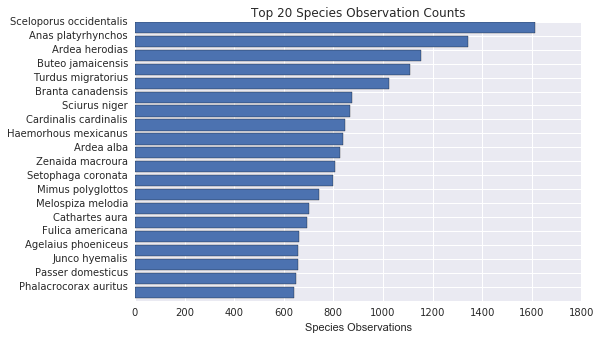

In [611]:
# Let's take a moment to examine the breakdown of species

# The number of species we want to plot
top_num = 20

top_species_ids = (-species_counts).argsort()[:top_num]
top_species_counts = species_counts[top_species_ids]
top_species_names = [species_lookup_dict[i] for i in top_species_ids]

plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
plt.barh(range(0,top_num), top_species_counts, tick_label=top_species_names)
plt.gca().invert_yaxis()
plt.xlabel("Species Observations")
plt.title("Top %d Species Observation Counts" % top_num)
plt.show()

As can be seen from these observations, the data in gbif.org is heavily skewed to species of scientific interest, rather than representing true population ratios.  For example, Sceloporus occidentalis (Western Fence Lizard) is the top observed species, while species such as squirrels, rabbits and sparrows are much further down.  Large birds (such as Egrets, Herons and Hawks) also appear to have a disproportionate influence on the data.

# EM

In [437]:
# Convert the grid species count dictionary to an array of arrays

# We want this to be in the following format:
#    [[    1  4720     1], [    1  9775     4], [    1 19996     1]...]
# Where each entry is an array of three elements, the first corresponding to the grid square id, 
# the second corresponding to the species id, and the third to the number of times that species
# was observed in this particular grid square
grid_species_counts = []

for grid_id in grid_species_count_dict.keys():
    for species_id in grid_species_count_dict[grid_id].keys():
        grid_species_counts.append([grid_id, species_id, grid_species_count_dict[grid_id][species_id]])

In [590]:
class EMClassifier(object):

    # Initializes with the number of topics
    def __init__(self, species_lookup_dict, data, num_topics):
        self.num_topics = num_topics
        self.species_lookup_dict = species_lookup_dict
        self.num_species = len(species_lookup_dict)
        
        counts = np.reshape(data[:,2], len(data)).tolist()[0]
        grid_ids = np.reshape(data[:,0], len(data)).tolist()[0]
        species_ids = np.reshape(data[:,1], len(data)).tolist()[0]
                             
        # Setup the species count matrix to keep track of which species have appeared 
        # in a particular lat-long grid square
        W = csr_matrix((counts,(grid_ids, species_ids)),shape=(num_grids, self.num_species))

        # Store the total number of observations in each lat-long grid square
        N = csr_matrix.sum(W, axis=1).reshape([num_grids,1])
            
        self.W = W
        self.N = N

        # Run EM
        self.run_EM()

    def run_EM(self):
        # Initialize our beliefs for theta and beta

        # Theta will be generated from a uniform initial distribution
        theta = np.random.rand(self.num_topics)
        # Normalize theta
        theta = theta / np.sum(theta)
        theta = theta.reshape([self.num_topics, 1])

        # Beta will be generated from a uniform normalized by column (species)
        beta = np.random.rand(self.num_topics, self.num_species)
        # Normalize Beta
        beta_row_sums = beta.sum(axis=1)
        beta = beta / beta_row_sums[:, np.newaxis]
        beta = beta
        self.lls = []
        
        self.smoothing = .00000000000000000001
        
        i = 0
        # While the algorithm hasn't converged, run EM
        while True:
            print "Iteration %d" % i
            i += 1
            
            # Run the E and M steps
            Q = self.E_step(beta, theta)
            beta, theta = self.M_step(Q)
            
            # Calculate the log-likelihood
            ll = np.multiply(Q, np.add(np.log(theta.T+self.smoothing), self.W.dot(np.log(beta.T+self.smoothing))).T)
            ll = np.sum(ll)
            self.lls.append(ll)
            
            if i > 1:
                if np.abs(self.lls[-1] - self.lls[-2]) < .1:
                    print "Converged!"
                    break

        # Print the topics after the last iteration
        self.print_topics(10, beta)
        self.plot_ll()

    # This should run the E step of the EM algorithm
    def E_step(self, beta, theta):
        # Create the new expectation matrix Q (grid squares by topic probabilities)
        Q = np.add(np.log(theta.T+self.smoothing), self.W.dot(np.log(beta.T+self.smoothing))).T
        Q = np.subtract(Q, logsumexp(Q, axis=0))
        # Exponentiate to move back to regular space
        Q = np.exp(Q)

        self.Q = Q
        return Q
        
    # This should run the M step of the EM algorithm
    def M_step(self, Q):
        # Maximize Theta
        theta = np.mean(Q, axis=1)
        theta = theta.reshape([self.num_topics, 1])
        self.theta = theta
        
        # Maximize Beta
        beta = (self.W.T.dot(Q.T)).T/np.dot(Q, self.N)
        self.beta = beta
        return beta, theta

    # This should print the top species per topic
    def print_topics(self, num_species, beta):
        print "Top Species Per Topic"
        for k in range(self.num_topics):
            a = np.array(beta[k])[0]
            ind = np.argsort(a)[-num_species:]
            species = []
            for an_ind in ind:
                species.append(self.species_lookup_dict[an_ind])
            print "Topic ", k, " species: ", species
            
    # Retrieves the top 'num_species' species in the same topic as the topic with the 
    # highest probability of having 'species_name' occur
    def get_top_species_in_topic(self, num_species, species_name):

        species_id = species_dictionary[species_name]
        
        # For this species, find the topic with the highest probability 
        # of this species occuring
        topic_id = np.argmax(self.beta[:,species_id])
        print("Topic ID %d" % topic_id)
        
        a = np.array(self.beta[topic_id])[0]
        ind = np.argsort(a)[-num_species:]
        species = []
        for an_ind in ind:
            species.append(self.species_lookup_dict[an_ind])
        return species
            
    # Plot the Log Likelihood per Iteration
    def plot_ll(self):
        plt.plot(range(len(self.lls)), self.lls)
        plt.title("Log Likelihood per Iteration with %d topics" % self.num_topics)
        plt.xlabel("EM Iteration")
        plt.ylabel("Log Likelihood")
        plt.show()

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

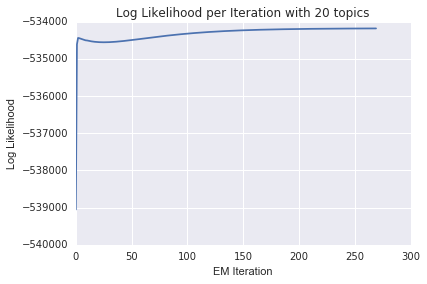

In [596]:
# ARE YOU SURE YOU WANT TO RUN THIS?
# emcclassifier = EMClassifier(species_lookup_dict=species_lookup_dict, data=np.matrix(grid_species_counts), num_topics=20)

In [1023]:
# CAREFUL!!!
# RUN THIS IF YOU WANT TO SEE THE DATA WE WORKED WITH
#emclassifier.Q = np.load('Data/em_q.npy')
#emclassifier.beta = np.load('Data/em_beta.npy')
#emclassifier.theta = np.load('Data/em_Theta.npy')

In [869]:
# CAREFUL!!!
# SAVE THE OUTPUT (THIS WILL OVERWITE ANY CURRENT OUTPUTS!!!)
#np.save('Data/em_q', emclassifier.Q)
#np.save('Data/em_beta', emclassifier.beta)
#np.save('Data/em_Theta', emclassifier.theta)

Above you can see how the Log-Likelihood quickly converges, and then quickly plateaus.  If you rerun the above code, you are not gauranteed to get the same results, since it depends to a large degree on the initial settings which are generated from a uniform distribution.  I have saved the outputs to the run of EM that I used to generate the report and you can load them with the above code.  I ran the EM a number of times for testing, and stopped since this run was so good, each of the top four deer species' most closely associated topic contained that deer species within the top 10!

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Converged!
Top Species Per Topic
Topic  0  species:  ['Zenaida macroura', 'Anas platyrhynchos', 'Passer domesticus', 'Haemorhous mexicanus', 'Peromyscus maniculatus', 'Odocoileus hemionus', 'Crotalus atrox', 'Buteo jamaicensis', 'Turdus migratorius', 'Sylvilagus audubonii']
Topic  1  species:  ['Setophaga coronata', 'Sciurus niger', 'Ardea alba', 'Branta canadensis', 'Cardinalis cardinalis', 'Turdus migratorius', 'Buteo jamaicensis', 'Ardea herodias', 'Anas platyrhynchos', 'Sceloporus occidentalis']


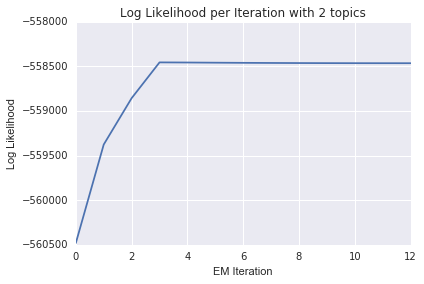

In [902]:
# 2 Topics
emc2 = EMClassifier(species_lookup_dict=species_lookup_dict, data=np.matrix(grid_species_counts), num_topics=2)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Converged!
Top Species Per Topic
Topic  0  species:  ['Sialia sialis', 'Setophaga coronata', 'Sciurus niger', 'Buteo jamaicensis', 'Ardea alba', 'Ardea herodias', 'Mimus polyglottos', 'Anolis carolinensis', 'Anas platyrhynchos', 'Cardinalis cardinalis']
Topic  1  species:  ['Anas platyrhynchos', 'Phrynosoma cornutum', 'Mimus polyglottos', 'Gopherus berlandieri', 'Ardea alba', 'Buteo jamaicensis', 'Crotalus atrox', 'Fulica americana', 'Cardinalis cardinalis', 'Ardea herodias']
Topic  2  species:  ['Egretta thula', 'Sylvilagus audubonii', 'Uta stansburiana', 'Ardea herodias', 'Sayornis nig

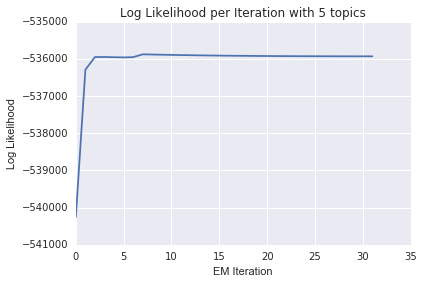

In [921]:
# 5 Topics
emc5 = EMClassifier(species_lookup_dict=species_lookup_dict, data=np.matrix(grid_species_counts), num_topics=5)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

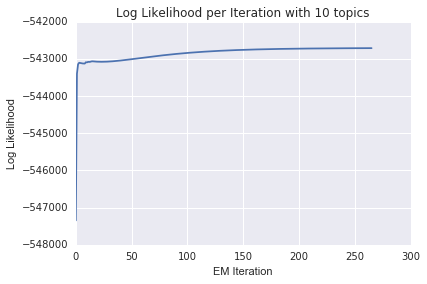

In [918]:
# 10 Topics
emc10 = EMClassifier(species_lookup_dict=species_lookup_dict, data=np.matrix(grid_species_counts), num_topics=10)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

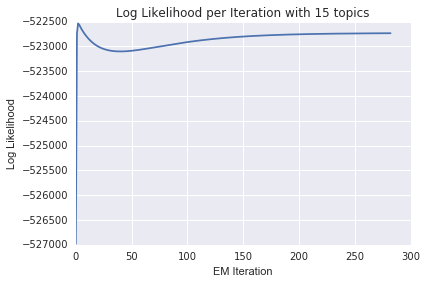

In [923]:
# 15 Topics
emc15 = EMClassifier(species_lookup_dict=species_lookup_dict, data=np.matrix(grid_species_counts), num_topics=15)

# Results

In [599]:
# Now let's gather the names of all of the deer species
deer_observations = data[data['family'] == 'Cervidae']
print "Observed deer %d times" % len(deer_observations)
deer_species = deer_observations['species'].dropna().unique()
print "The observed deer in the US came from %d unique species:" % len(deer_species)
print deer_species

Observed deer 1285 times
The observed deer in the US came from 7 unique species:
['Cervus elaphus' 'Odocoileus virginianus' 'Odocoileus hemionus'
 'Alces americanus' 'Rangifer tarandus' 'Axis axis' 'Cervus nippon']


In [600]:
# Let's find the clusters that these deer belong to with the highest probability and 
# look at the other species that are clustered with them

# Loop over each deer species
for i in range(len(deer_species)):
    deer_species_name = deer_species[i]
    print "---------------------"
    print "Deer Species: %s" % deer_species_name
    print "Most likely to co-occur:"
    print emclassifier.get_top_species_in_topic(10, deer_species_name)

---------------------
Deer Species: Cervus elaphus
Most likely to co-occur:
Topic ID 14
['Ursus americanus', 'Zonotrichia leucophrys', 'Phrynosoma cornutum', 'Toxostoma curvirostre', 'Antilocapra americana', 'Holbrookia lacerata', 'Cervus elaphus', 'Bison bison', 'Cyanocitta stelleri', 'Peromyscus maniculatus']
---------------------
Deer Species: Odocoileus virginianus
Most likely to co-occur:
Topic ID 17
['Sayornis phoebe', 'Sialia sialis', 'Setophaga coronata', 'Meleagris gallopavo', 'Spinus tristis', 'Terrapene carolina', 'Podilymbus podiceps', 'Junco hyemalis', 'Melospiza melodia', 'Odocoileus virginianus']
---------------------
Deer Species: Odocoileus hemionus
Most likely to co-occur:
Topic ID 9
['Pipilo maculatus', 'Buteo swainsoni', 'Pica hudsonia', 'Falco sparverius', 'Streptopelia decaocto', 'Antilocapra americana', 'Meleagris gallopavo', 'Sceloporus graciosus', 'Buteo jamaicensis', 'Odocoileus hemionus']
---------------------
Deer Species: Alces americanus
Most likely to co-

# Co-occurance Analysis

In [444]:
def grab_species_lat_long(species_name):
    species_data = data[data['species'] == species_name]
    print "Num observations of %s: %d " % (species_name, len(species_data))
    lats = species_data['decimallatitude'].tolist()
    lons = species_data['decimallongitude'].tolist()
    return lats, lons

In [737]:
global_bin_longs = longs
global_bin_lats = lats

In [1017]:
def plot_topics(num_topics, emc, colormap='spring', alaska=False):
    all_lats = []
    all_lons = []
    cols = []
    
    # Setup the graph
    if not alaska:
        plt.figure(figsize=(13,10))
        m = Basemap(projection='merc',llcrnrlat=21, urcrnrlat=54, llcrnrlon=-129,  urcrnrlon=-63)
    else:
        m = Basemap(projection='merc',llcrnrlat=51, urcrnrlat=75, llcrnrlon=-180,  urcrnrlon=-126)
        plt.figure(figsize=(8,8))
    
    # Plot the background
    Q = emc.Q

    lon_bins_2d, lat_bins_2d = np.meshgrid(global_bin_longs, global_bin_lats)

    density = np.zeros(7381)
    for i in range(0,7381):
        if all(j >= .01 for j in Q[:, i]):
            density[i] = np.nan
        else:
            density[i] = np.argmax(Q[:, i])
    density = density.reshape(61, 121)
    #density[density >= np.mean(density)+.5] = numpy.nan

    xs, ys = m(lon_bins_2d, lat_bins_2d)
    
    # Remove invalid values from the density matrix
    densitym = densitym = ma.masked_invalid(density)#  ma.array(density,mask=np.isnan(density))
    
    plt.pcolormesh(xs, ys, densitym, cmap=colormap,alpha=.9)
    
    m.drawmapboundary(fill_color='lightblue') # fill to edge
    m.drawcountries()
    m.fillcontinents(color='white',lake_color='lightblue',zorder=0)
    
    # Create the legend patches
    legend_labels = []
    for i in range(num_topics):
        legend_labels.append('Topic ' + str(i))
    colors = sns.color_palette(colormap, num_topics)
    legend_patches = [matplotlib.patches.Patch(color=C, label=L, alpha=.9) for C, L in zip(colors, legend_labels)]

    # Plot the legend
    plt.legend(handles=legend_patches, fancybox=True,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)    
    
    # Add the title
    plt.title(str(num_topics) + ' EM Topics', fontsize=20)
    plt.show()

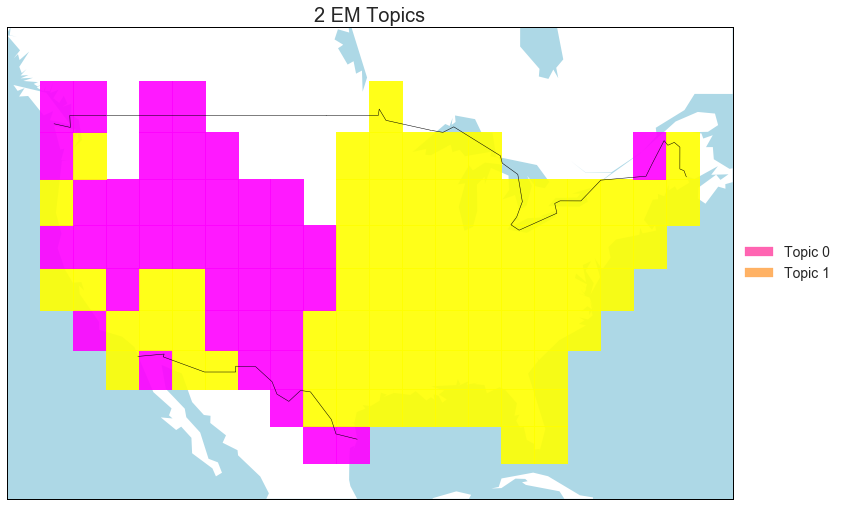

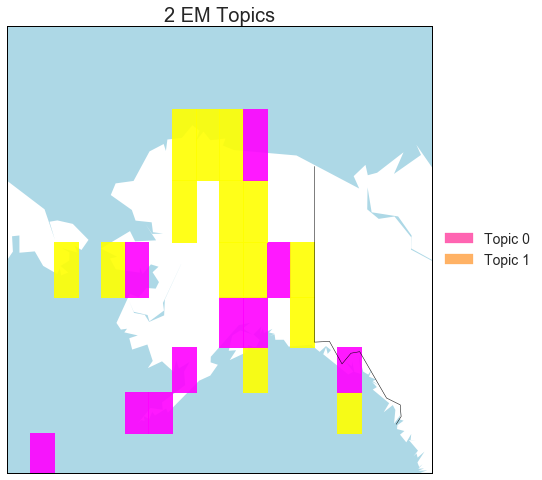

In [1005]:
# 2 Topics
plot_topics(2, emc2)
plot_topics(2, emc2, alaska=True)

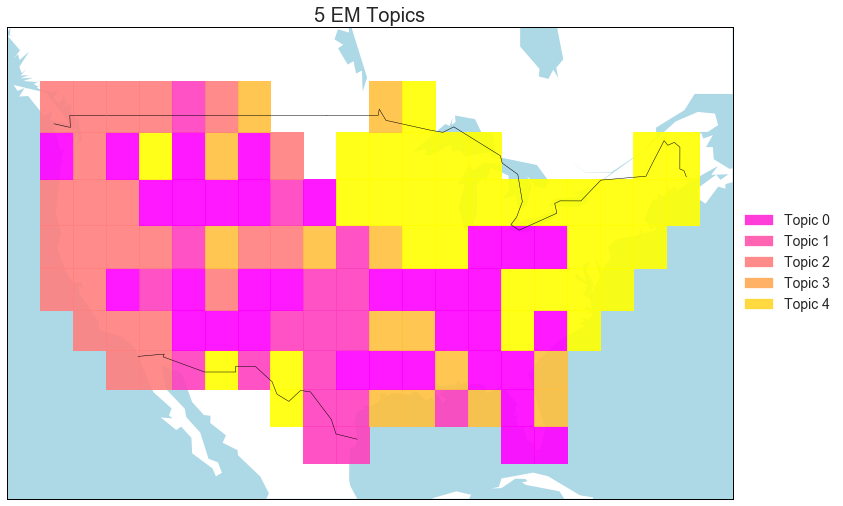

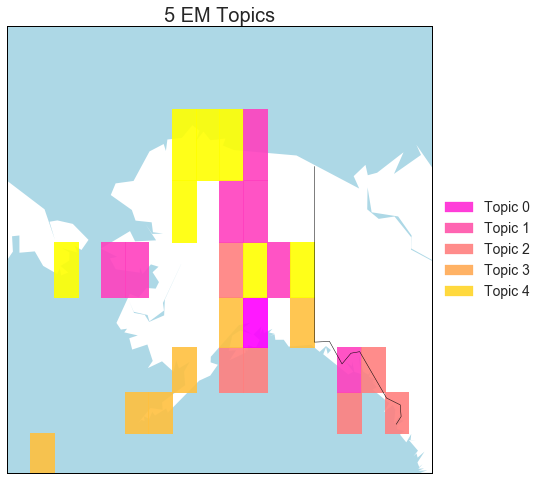

In [1006]:
# 5 Topics
plot_topics(5, emc5)
plot_topics(5, emc5,alaska=True)

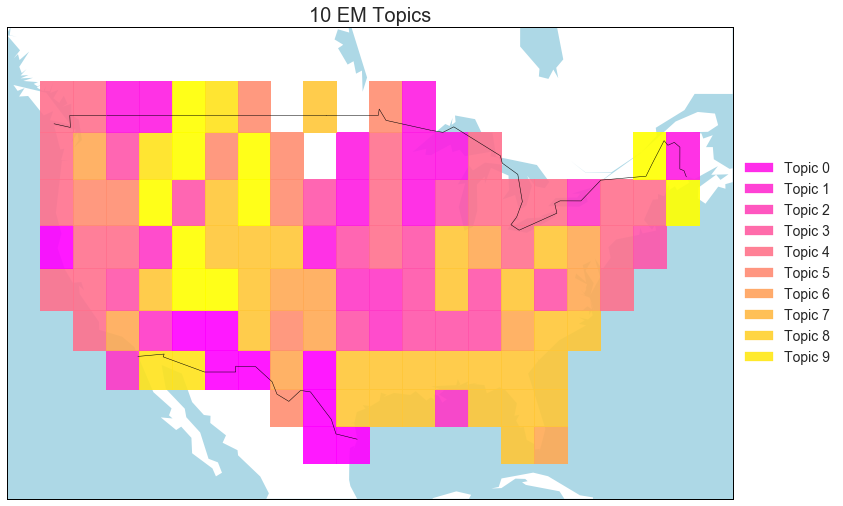

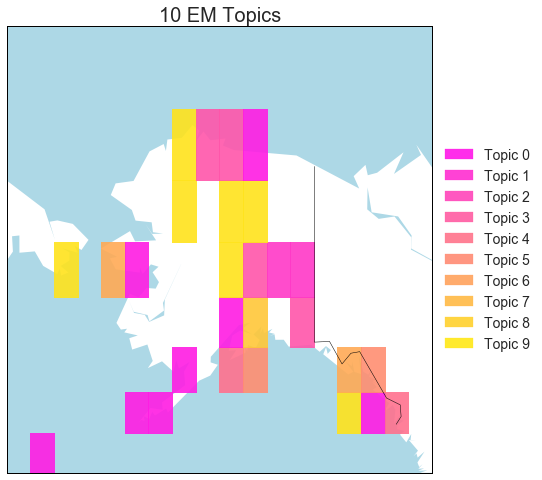

In [1007]:
# 10 Topics
plot_topics(10, emc10)
plot_topics(10, emc10,alaska=True)

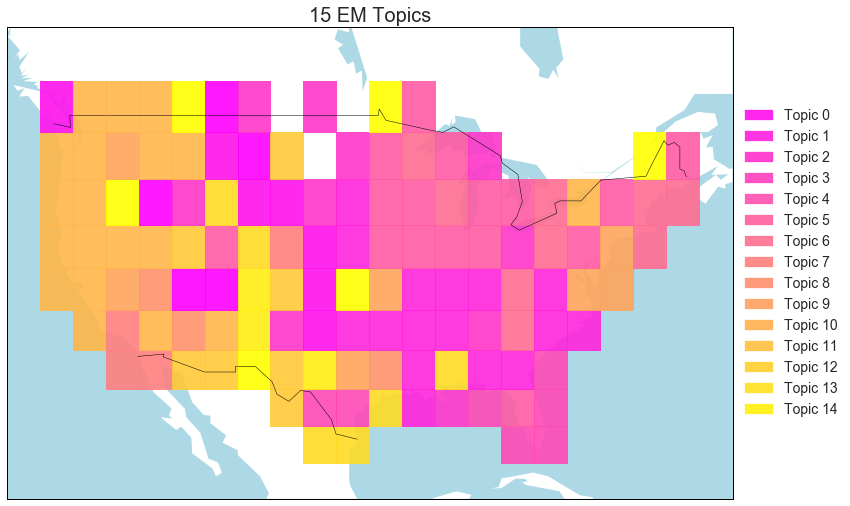

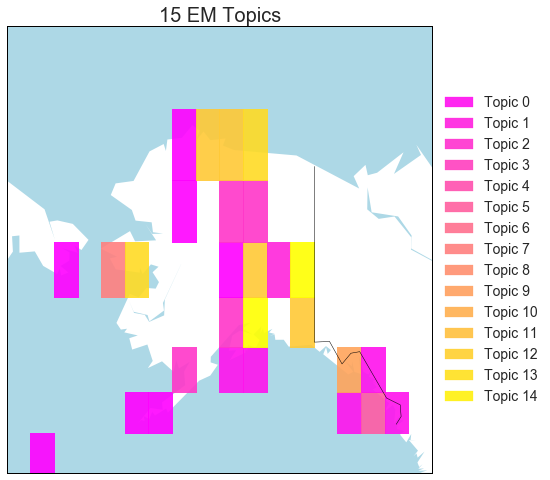

In [1008]:
# 15 Topics
plot_topics(15, emc15)
plot_topics(15, emc15,alaska=True)

In [1024]:
# 20 Topics
plot_topics(20, emcclassifier)
plot_topics(20, emcclassifier, True)

AttributeError: type object 'EMClassifier' has no attribute 'Q'

In [883]:
def plot_cooccuring_species(main_species, species_names, common_names, colormap, topic_id, alaska=False):
    all_lats = []
    all_lons = []
    cols = []
    
    # Setup the graph
    if not alaska:
        plt.figure(figsize=(13,10))
        m = Basemap(projection='merc',llcrnrlat=21, urcrnrlat=54, llcrnrlon=-129,  urcrnrlon=-63)
    else:
        m = Basemap(projection='merc',llcrnrlat=51, urcrnrlat=75, llcrnrlon=-180,  urcrnrlon=-126)
        plt.figure(figsize=(8,8))
    
    # Plot the background
    Q = emclassifier.Q

    lon_bins_2d, lat_bins_2d = np.meshgrid(global_bin_longs, global_bin_lats)

    density = np.zeros(7381)
    for i in range(0,7381):
        density[i] = Q[topic_id, i]
    density = density.reshape(61, 121)
    #density[density >= np.mean(density)+.5] = numpy.nan

    xs, ys = m(lon_bins_2d, lat_bins_2d)
    
    # Remove invalid values from the density matrix
    densitym = densitym = ma.masked_invalid(density)#  ma.array(density,mask=np.isnan(density))
    
    plt.pcolormesh(xs, ys, densitym, cmap='Greys',alpha=.2)
    
    # Plot the main species
    main_lons, main_lats = grab_species_lat_long(main_species)
    main_x, main_y = m(main_lats, main_lons)
    
    for i, species_name in enumerate(species_names):
        lons, lats = grab_species_lat_long(species_name)
        all_lats.extend(lats)
        all_lons.extend(lons)
        cols.extend(np.ones(len(lats)) * i)

    x, y = m(all_lats,all_lons)
    m.drawmapboundary(fill_color='lightblue') # fill to edge
    m.drawcountries()
    m.fillcontinents(color='white',lake_color='lightblue',zorder=0)

    m.scatter(main_x, main_y,80,marker="o",c='black',alpha=0.7,zorder=5,label=main_species)

    # Plot 
    m.scatter(x,y,30,marker="o", lw = 0,c=cols,cmap=colormap,alpha=0.8)

    #legend_labels  = [main_species] + species_names
    legend_labels = common_names
    
    # Create the legend patches
    colors = [(0,0,0)] + sns.color_palette(colormap, len(species_names))
    legend_patches = [matplotlib.patches.Patch(color=C, label=L) for
                  C, L in zip(colors, legend_labels)]

    # Plot the legend
    plt.legend(handles=legend_patches, fancybox=True,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)    
    
    # Add the title
    plt.title(common_names[0] + ' Co-occurance', fontsize=20)
    plt.show()

Num observations of Cervus elaphus: 144 
Num observations of Ursus americanus: 143 
Num observations of Zonotrichia leucophrys: 595 
Num observations of Phrynosoma cornutum: 155 
Num observations of Toxostoma curvirostre: 89 
Num observations of Antilocapra americana: 100 
Num observations of Holbrookia lacerata: 32 
Num observations of Bison bison: 71 
Num observations of Cyanocitta stelleri: 212 
Num observations of Peromyscus maniculatus: 243 


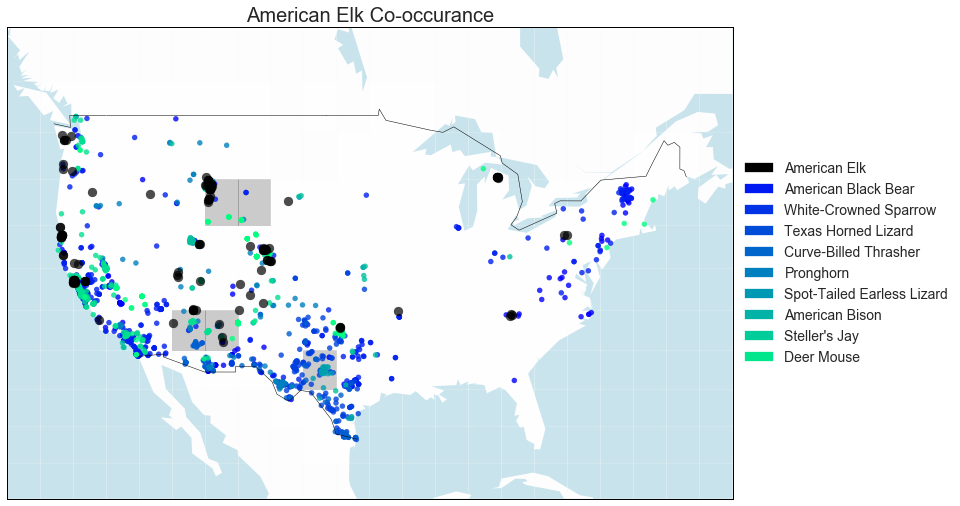

In [884]:
# American Elk
plot_cooccuring_species('Cervus elaphus', ['Ursus americanus', 'Zonotrichia leucophrys', 
    'Phrynosoma cornutum', 'Toxostoma curvirostre', 'Antilocapra americana', 
    'Holbrookia lacerata', 'Bison bison', 'Cyanocitta stelleri', 
    'Peromyscus maniculatus'],
    ['American Elk', 'American Black Bear', 'White-Crowned Sparrow', 'Texas Horned Lizard', 
    'Curve-Billed Thrasher', 'Pronghorn', 'Spot-Tailed Earless Lizard', 
    'American Bison', 'Steller\'s Jay', 'Deer Mouse'],
    'winter', 14)

Num observations of Odocoileus virginianus: 630 
Num observations of Sayornis phoebe: 382 
Num observations of Sialia sialis: 395 
Num observations of Setophaga coronata: 803 
Num observations of Meleagris gallopavo: 465 
Num observations of Spinus tristis: 474 
Num observations of Terrapene carolina: 332 
Num observations of Podilymbus podiceps: 407 
Num observations of Junco hyemalis: 656 
Num observations of Melospiza melodia: 706 


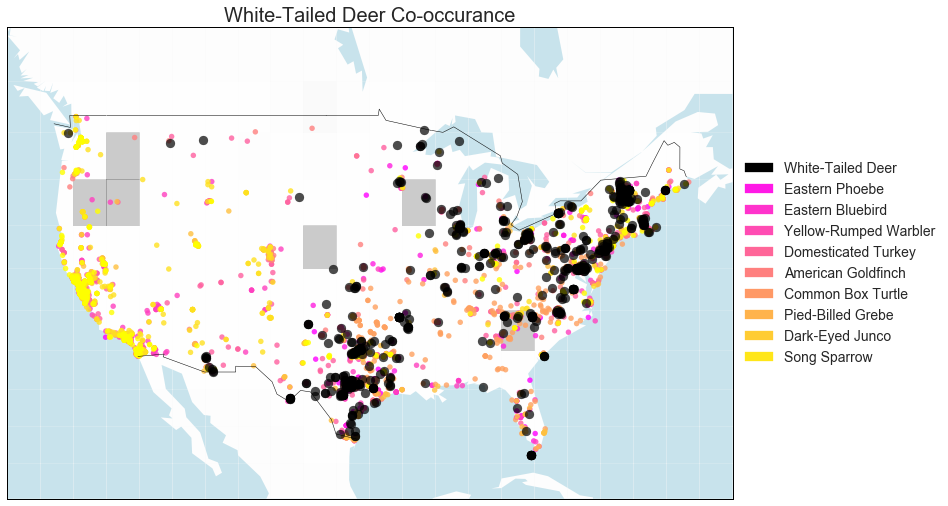

In [876]:
# White-tailed deer
plot_cooccuring_species('Odocoileus virginianus', ['Sayornis phoebe', 'Sialia sialis', 
    'Setophaga coronata', 'Meleagris gallopavo', 'Spinus tristis', 'Terrapene carolina', 
    'Podilymbus podiceps', 'Junco hyemalis', 'Melospiza melodia'],
    ['White-Tailed Deer', 'Eastern Phoebe', 'Eastern Bluebird', 'Yellow-Rumped Warbler',
    'Domesticated Turkey', 'American Goldfinch', 'Common Box Turtle', 'Pied-Billed Grebe',
    'Dark-Eyed Junco', 'Song Sparrow'],
    'spring', 17)

Num observations of Odocoileus hemionus: 413 
Num observations of Pipilo maculatus: 257 
Num observations of Buteo swainsoni: 165 
Num observations of Pica hudsonia: 75 
Num observations of Falco sparverius: 462 
Num observations of Streptopelia decaocto: 325 
Num observations of Antilocapra americana: 100 
Num observations of Meleagris gallopavo: 465 
Num observations of Sceloporus graciosus: 54 
Num observations of Buteo jamaicensis: 1114 


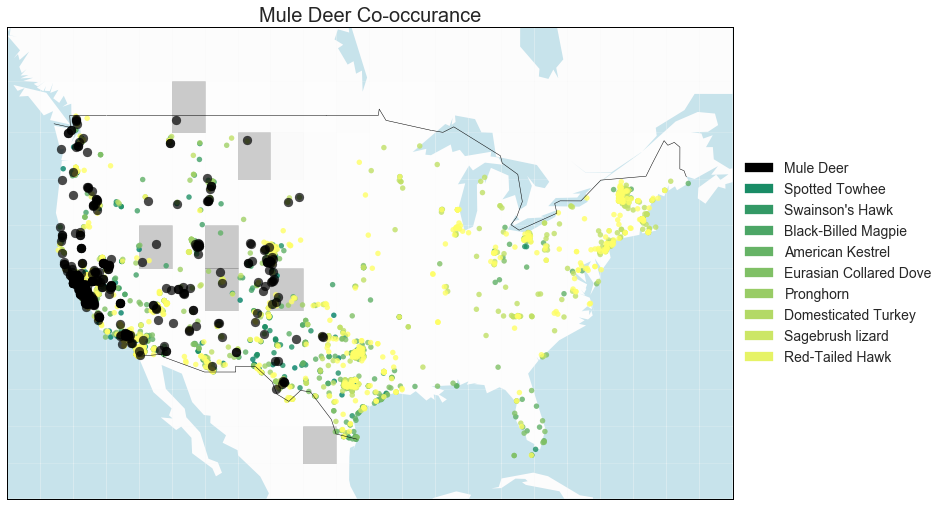

In [877]:
# Mule Deer
plot_cooccuring_species('Odocoileus hemionus', ['Pipilo maculatus', 'Buteo swainsoni', 
    'Pica hudsonia', 'Falco sparverius', 'Streptopelia decaocto', 'Antilocapra americana', 
    'Meleagris gallopavo', 'Sceloporus graciosus', 'Buteo jamaicensis'],
    ['Mule Deer', 'Spotted Towhee', 'Swainson\'s Hawk', 'Black-Billed Magpie', 
     'American Kestrel', 'Eurasian Collared Dove', 'Pronghorn', 'Domesticated Turkey', 
     'Sagebrush lizard', 'Red-Tailed Hawk'],
    'summer', 9)

Num observations of Alces americanus: 83 
Num observations of Turdus migratorius: 1033 
Num observations of Chrysemys picta: 226 
Num observations of Passerella unalaschcensis: 12 
Num observations of Cervus elaphus: 144 
Num observations of Mergus merganser: 192 
Num observations of Haliaeetus leucocephalus: 400 
Num observations of Microtus oeconomus: 76 
Num observations of Sterna paradisaea: 31 
Num observations of Vulpes lagopus: 97 


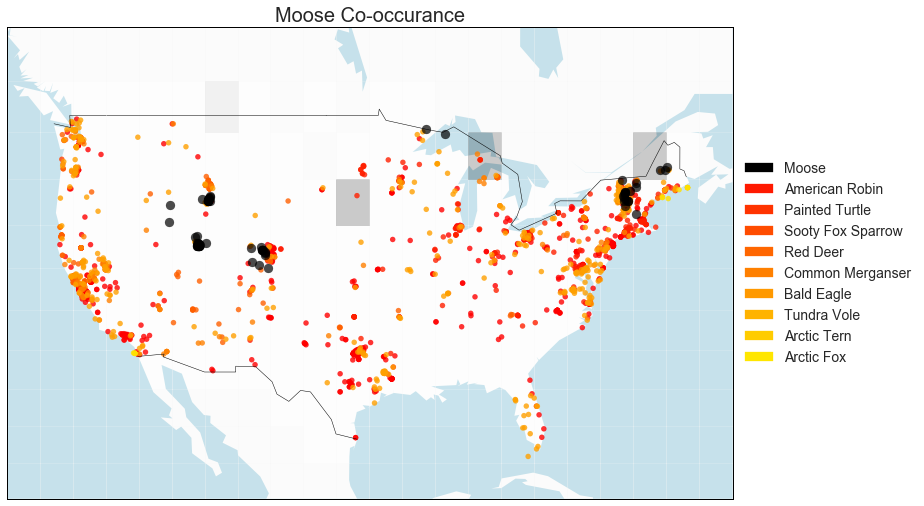

Num observations of Alces americanus: 83 
Num observations of Turdus migratorius: 1033 
Num observations of Chrysemys picta: 226 
Num observations of Passerella unalaschcensis: 12 
Num observations of Cervus elaphus: 144 
Num observations of Mergus merganser: 192 
Num observations of Haliaeetus leucocephalus: 400 
Num observations of Microtus oeconomus: 76 
Num observations of Sterna paradisaea: 31 
Num observations of Vulpes lagopus: 97 


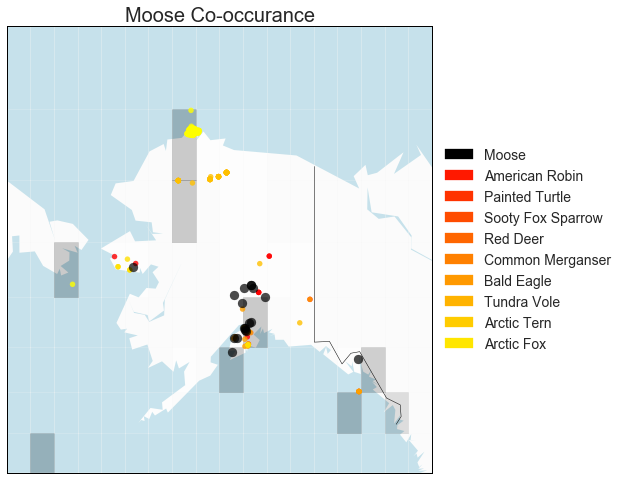

In [878]:
# American Moose
plot_cooccuring_species('Alces americanus', ['Turdus migratorius', 'Chrysemys picta', 
    'Passerella unalaschcensis', 'Cervus elaphus', 'Mergus merganser',  
    'Haliaeetus leucocephalus', 'Microtus oeconomus', 'Sterna paradisaea', 'Vulpes lagopus'],
    ['Moose', 'American Robin', 'Painted Turtle', 'Sooty Fox Sparrow', 'Red Deer', 
    'Common Merganser', 'Bald Eagle', 'Tundra Vole', 'Arctic Tern', 'Arctic Fox'],
    'autumn', 19)
plot_cooccuring_species('Alces americanus', ['Turdus migratorius', 'Chrysemys picta', 
    'Passerella unalaschcensis', 'Cervus elaphus', 'Mergus merganser',  
    'Haliaeetus leucocephalus', 'Microtus oeconomus', 'Sterna paradisaea', 'Vulpes lagopus'],
    ['Moose', 'American Robin', 'Painted Turtle', 'Sooty Fox Sparrow', 'Red Deer', 
    'Common Merganser', 'Bald Eagle', 'Tundra Vole', 'Arctic Tern', 'Arctic Fox'],
    'autumn', 19, True)